In [4]:
# !git clone https://github.com/auto-Dog/MOAC_deep.git
%cd /kaggle/working/MOAC_deep/src
!git pull
# !mv dataset MOAC_deep/
!pip install torchsummary

/kaggle/working/MOAC_deep/src
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 7 (delta 4), reused 7 (delta 4), pack-reused 0 (from 0)
Unpacking objects: 100% (7/7), 962 bytes | 481.00 KiB/s, done.
From https://github.com/auto-Dog/MOAC_deep
   4af0cef..de051ac  main       -> origin/main
Updating 4af0cef..de051ac
Fast-forward
 model_Umod_snr0.pth.ori | Bin 4176556 -> 0 bytes
 readme.md               |   5 +++++
 src/gen_dataset.py      |  18 ++----------------
 src/moac_dataset.py     |   4 ++--
 src/train.py            |   8 ++++----
 5 files changed, 13 insertions(+), 22 deletions(-)
 delete mode 100644 model_Umod_snr0.pth.ori
 create mode 100644 readme.md


In [ ]:
! python evaluate.py

In [ ]:
# ! rm -rf /kaggle/working/MOAC_deep/dataset/*
# ! python gen_dataset.py
# print('Done')

In [ ]:
! python train.py --batchsize 64

In [1]:
from restore_module import TinyUNet
from moac_dataset import MOACDataset
import torch
import torch.nn as nn
import numpy as np
import time
from utils.edge_loss import EdgeLoss

pth_tar_location = '../model_Umod5.pth'
dataset = MOACDataset('/kaggle/working/MOAC_deep/dataset', 'test')
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
model = TinyUNet(4,1,bilinear=True).cuda()
criterion1 = nn.MSELoss()
criterion2 = EdgeLoss()

from torchsummary import summary
summary(model, input_size=(4,256,14))
model.load_state_dict(torch.load(pth_tar_location, map_location='cpu'))
model.eval()
for gt, noised, gt_sum in train_loader:  # 获取第0个样本的GT和噪声图像
    time0 = time.time()
    with torch.no_grad():
        outs = model(noised.cuda())
    gt = gt.cuda()
    gt_sum = gt_sum.cuda()
    finish_time = time.time()-time0
    print('Using {} s'.format(finish_time))
    print('Size of gt, noised, gt_sum:{}{}{}'\
        .format(gt.size(), noised.size(), gt_sum.size()))
    s_estimate = outs.squeeze().cpu().detach().numpy()
    d_data = gt.squeeze().cpu().detach().numpy()
    print('L_pixel:',criterion1(outs,gt))
    print('L_target:',criterion1(torch.sum(outs.squeeze(1),dim=1),gt_sum))
    print('L_edge:',criterion2(outs,gt))
    print(np.mean(np.abs(np.sum(s_estimate,axis=0)-np.sum(d_data,axis=0))**2))
    break

ModuleNotFoundError: No module named 'restore_module'

Test a real Signal Image

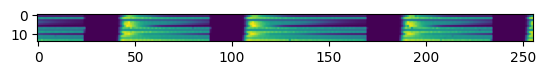

In [44]:
from PIL import Image
import matplotlib.pyplot as plt
from scipy import signal
from single_inference import inference
import numpy as np
import time
M_users = 14
L_symbols = 256
loaded_image = Image.open('../test_images/data_1.png').convert('L')
# loaded_image = Image.open('../dataset/test/GT/00050.png').convert('L')
loaded_array = np.array(loaded_image)
# d_data = (loaded_array.astype('float32') - 128) / 20.  # 将0-255的整数转换回小数
d_data = loaded_array.astype('float32') / 255.
h_coff = np.exp(1j*np.random.uniform(0,1,(M_users,1)) * 4* np.pi /4)
SNR_db_global = 0
plt.imshow(d_data)
# plt.colorbar()
plt.show()

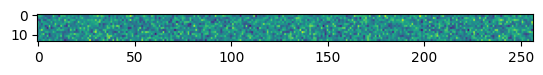

In [45]:
def awgn(x, snr):
    '''Add AWGN(complex)
    x: numpy array
    snr: int, dB
    '''
    len_x = x.flatten().shape[0]
    Ps = np.sum(np.abs(x)**2) / len_x
    Pn = Ps / (np.power(10, snr / 10))
    noise_r = np.random.randn(x.shape[0],x.shape[1]) * np.sqrt(Pn)/np.sqrt(2)
    noise_i = np.random.randn(x.shape[0],x.shape[1]) * np.sqrt(Pn)/np.sqrt(2)
    noise = noise_r + 1j*noise_i
    return x + noise

def get_pn(x, snr):
    len_x = x.flatten().shape[0]
    Ps = np.sum(np.abs(x)**2) / len_x
    Pn = Ps / (np.power(10, snr / 10))    
    return Pn

def signal_snr_db(y,yn):
    ps = np.mean(np.abs(y)**2)
    pn = np.mean(np.abs(y-yn)**2)
    snr = ps/pn
    snr_db = 10*np.log10(snr)
    return snr_db

# 用优化后的方法生成噪声信号：
def distortion_func(image:np.ndarray,h_coff,SNR_db=0):
    # 添加混叠，以及信道系数
#     np.random.seed()   # 保证噪声随机化
    # image = image.numpy()
#     image = (image-np.min(image))/(80.-np.min(image)) # 归一化
    blur_kernel = np.zeros((2*M_users-1,3))
    kernel_height = 2*M_users-1
    blur_kernel[0:M_users,1] = 1.
    blur_kernel[M_users:,0] = 1.
    blur_kernel_1d = np.array([1.]*M_users)
    blur_kernel_r = np.rot90(blur_kernel,2)*(1+0j)   # 注意，必须将kernel先旋转180°，才能使实际卷积函数按照“对应位置相乘”运行卷积
    # print(blur_kernel_r)
    d_data_col = np.hstack((image,np.zeros((M_users,1))))   # 额外加一列

    # 乘信道系数
    h_coff = h_coff.reshape(-1,1)
    # print(h_coff)   # debug
    hh_expand = np.tile(h_coff,(1,d_data_col.shape[1]))    # 每行是hi
    d_data_h = d_data_col*hh_expand
    # print(hh_expand[:,:10]) # debug
    # 加卷积
    convSame = signal.convolve2d(d_data_h, blur_kernel_r, mode='same')# 等效为一维线卷积，实现更快
    # 加噪
    convSame = awgn(convSame,SNR_db) # add white gaussian noise
    convSame = np.complex64(convSame)   # 32bit for real and imag
    return convSame

# # 用采样方程生成噪声信号：
# def distortion_func(image:np.ndarray,h_coff,SNR_db=0):
#     D_array = np.zeros([M_users*(L_symbols+1)-1, M_users*L_symbols])*(1+0j)
#     for idx in range(M_users*L_symbols):    # 按列依次赋值
#         D_array[np.arange(M_users)+idx, idx] = h_coff[np.mod(idx,M_users)]
#     d_data_vec = image.T.reshape(-1,1)
#     y_out = D_array @ d_data_vec
#     y_out = np.vstack((y_out,[0.]))    # 为了能形成信号矩阵
#     y_out = awgn(y_out,SNR_db) # add white gaussian noise
#     y_out_mat = y_out.reshape(L_symbols+1,M_users).T
#     return y_out_mat

y_mat = distortion_func(d_data,h_coff,SNR_db_global)
plt.imshow(y_mat.real)
plt.show()
noised_seq = y_mat.T.reshape(-1) # M x L -> ML x 1 seq
y_out = noised_seq[:-1].copy()  # 得到过采样有噪失真序列

1. Align assumption estimation

In [46]:
st_time = time.time()
MthFiltersIndex = (np.arange(L_symbols) + 1) * M_users - 1
output = y_out[MthFiltersIndex]
print(np.mean(np.abs(output-np.sum(d_data,axis=0))**2))
print('Time cost:',1000*(time.time()-st_time))

64.66527
Time cost: 0.6170272827148438


2. ML estimation

Time cost: 6864.558219909668


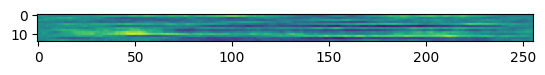

7239.693479597253


In [47]:
import scipy.sparse.linalg as srlg
from scipy.sparse import csr_matrix
st_time = time.time()
D_array = np.zeros([M_users*(L_symbols+1)-1, M_users*L_symbols])*(1+0j)
for idx in range(M_users*L_symbols):    # 按列依次赋值
    D_array[np.arange(M_users)+idx, idx] = h_coff[np.mod(idx,M_users)]
# print(D_array.shape,y_out.shape)
# restored = np.linalg.lstsq(D_array,y_out)[0]    # 直接求解：5000x5000~29s
D_array_csr = csr_matrix(D_array)               # 稀疏矩阵求解：5000x5000~2.7s
pn = get_pn(y_out.flatten(),SNR_db_global)
noise_sigma = csr_matrix(np.diag([pn]*(M_users*(L_symbols+1)-1)))
noise_sigma_inv = srlg.inv(noise_sigma)
# d_inv_csr = srlg.inv(D_array_csr.conj().T@D_array_csr)
# restored = d_inv_csr @ D_array_csr.conj().T @ y_out  
d_inv_csr = srlg.inv(D_array_csr.conj().T@noise_sigma_inv@D_array_csr)
restored = d_inv_csr @ D_array_csr.conj().T @noise_sigma_inv@ y_out  
x_re_mat0 = restored.flatten()[:L_symbols*M_users].reshape(L_symbols,M_users).T
x_re_mat0 = np.real(x_re_mat0)
print('Time cost:',1000*(time.time()-st_time))
plt.imshow(x_re_mat0)
plt.show()
print(np.mean(np.abs(np.sum(x_re_mat0,axis=0)-np.sum(d_data,axis=0))**2))
# MxL>5000时，运行缓慢


3. LMMSE estimation

In [ ]:
st_time = time.time()
# 计算每一行的均值
mean_vector = np.mean(d_data, axis=1)
mu_vec = csr_matrix(np.tile(mean_vector.flatten(),L_symbols))

# 计算每一行的方差
variance_vector = np.var(d_data, axis=1)
d_vector = np.tile(variance_vector.flatten(),L_symbols)
d_hat_mat = csr_matrix(np.diag(d_vector))


pn = get_pn(y_out.flatten(),SNR_db_global)
noise_sigma = csr_matrix(np.diag([1.]*(M_users*(L_symbols+1)-1)))
tmp_inv_mat = srlg.inv(D_array_csr @ d_hat_mat @ D_array_csr.T.conj() + noise_sigma)
a_mat = d_hat_mat @ D_array_csr.T.conj() @ tmp_inv_mat
I_mat = np.diag([1.]*(M_users*L_symbols))
# print(a_mat.shape)
restored = a_mat @ y_out.reshape(-1,1) + (I_mat - a_mat @ D_array_csr) @ mu_vec.reshape(-1,1)
# print(restored.shape)
x_re_mat1 = restored.flatten()[:L_symbols*M_users].reshape(L_symbols,M_users).T
x_re_mat1 = np.real(x_re_mat1)
print('Time cost:',1000*(time.time()-st_time))
plt.imshow(x_re_mat1)
plt.show()
print(x_re_mat1.shape,d_data.shape)
sum_est = np.array(np.sum(x_re_mat1,axis=0))    # matrix to array
sum_gt = np.sum(d_data,axis=0)
print(np.mean(np.abs(sum_est-sum_gt)**2))

# # compare result and GT
# x_ticks = np.linspace(0,1,len(sum_est.flatten()))
# plt.plot(x_ticks,sum_est.flatten(),'b-',
#          x_ticks,sum_gt.flatten(),'black')
# plt.show()

4. Our estimation

In [ ]:
# hh = np.array([1.]*20).reshape(-1,1)
st_time = time.time()
output,image = inference(y_out.flatten(),'../model_Umod5.pth',M_users,L_symbols,h_coff,SNR_db_global)
image = image.real
print('Time cost:',1000*(time.time()-st_time))
plt.imshow(image)
plt.show()
print('Our result:',np.mean(np.abs(np.sum(image,axis=0)-np.sum(d_data,axis=0))**2))
print('Signal Power:',np.mean(np.sum(d_data,axis=0)**2))

print('Result SNR:',signal_snr_db(np.sum(d_data,axis=0),np.sum(image,axis=0)) )

Wiener itself

In [ ]:
from numpy import fft
def wiener_deconv(input, kernel, SNR_db=0):       
    ''' 
    Winner filter with given blur kernel
    ---
    input: M长序列，可能包含周边padding
    kernel: 补全至M的卷积核
    '''
    K = 1 / (np.power(10, SNR_db / 10))
    input_fft = fft.fft(input)
    kernel_fft = fft.fft(kernel)
    kernel_fft_1 = np.conj(kernel_fft) / (np.abs(kernel_fft) ** 2 + K)
    result = fft.ifft(input_fft * kernel_fft_1)
    # result = np.abs(fft.fftshift(result))
    return result

st_time = time.time()
y_out = y_out.flatten()
pad_len = len(y_out)
blur_kernel_1d = np.array([1.]*M_users)
blur_kernel_1d = np.hstack((blur_kernel_1d,np.array([0]*(pad_len-len(blur_kernel_1d)))))
x_re_pad = wiener_deconv(y_out,blur_kernel_1d,SNR_db_global)   # 低SNR下，用更低的SNR估计取得效果更好
x_re_mat = x_re_pad[:L_symbols*M_users].reshape(L_symbols,M_users).T
hh_expand = np.tile(h_coff,(1,L_symbols))    # 每行是hi
x_re_mat = x_re_mat/hh_expand
x_re_mat = np.real(x_re_mat)
print('Time cost:',1000*(time.time()-st_time))
# print(hh_expand[:5,:5])
plt.imshow(x_re_mat.real)
plt.show()
print(np.mean(np.abs(np.sum(x_re_mat,axis=0)-np.sum(d_data,axis=0))**2))

# # compare winner result and GT
# x_ticks = np.linspace(0,1,len(np.sum(x_re_mat,axis=0).flatten()))
# # est_data_ma = np.convolve(np.sum(x_re_mat,axis=0).flatten(), np.ones(10), "same") / 10 # Use Moving average can enhance the result.
# plt.plot(x_ticks,np.sum(x_re_mat,axis=0).flatten(),'b-',
#          x_ticks,np.sum(d_data,axis=0).flatten(),'black')
# plt.show()
